In this part, we'll try to plot the time-course of 1 IC extracted from the EEG of 1 subject on 1 trial.

# First let's extract the time scale data and the time-course data from the .mat file:

In [1]:
import numpy as np
from loader import load

In [2]:
directory = "E:/timot/Documents/1 - Centrale Marseille/0.5 - Semestre S8/Stage/NIC_250819"
file = "FCK_LOCKED_IC_JYOTIKA_250819.mat"

data, n_IC, n_subj, n_trials = load(directory, file, tfr="Comp256Hz")

loading the raw timecourses...
The independent component IC1 of the subject 20 is not in the .mat file.
The independent component IC1 of the subject 21 is not in the .mat file.
The independent component IC2 of the subject 5 is not in the .mat file.
The independent component IC2 of the subject 9 is not in the .mat file.
The independent component IC3 of the subject 1 is not in the .mat file.
The independent component IC3 of the subject 17 is not in the .mat file.
The independent component IC3 of the subject 23 is not in the .mat file.
The independent component IC4 of the subject 12 is not in the .mat file.
Computing and loading the time-frequency wavelet transformation of all subjects for all IC, 22 trials...
Loaded subject 1
Loaded subject 2
Loaded subject 3
Loaded subject 4
Loaded subject 5
Loaded subject 6
Loaded subject 7
Loaded subject 8
Loaded subject 9
Loaded subject 10
Loaded subject 11
Loaded subject 12
Loaded subject 13
Loaded subject 14
Loaded subject 15
Loaded subject 16
Load

# Now we'll implement the HMM method.

### Cumputing functions:

In [3]:
from sklearn.decomposition import PCA
from hmmlearn import hmm
import scipy.signal as signal
import pickle

In [ ]:
'''
!!! I removed the PCA: very different results
'''

In [4]:
# The embedx function copies the `x` array len(lags) times into `xe`
# with lags (i.e. time delays) between lags[0] and lags[-1] (we implement the time-delay array for the HMM).

def embedx(x, lags):
    
    Xe = np.zeros((x.shape[1], x.shape[0],  len(lags)))

    for l in range(len(lags)):
        Xe[:, :, l] = np.roll(x, lags[l], axis=0).swapaxes(0, 1)

    # Remove edges
    valid = np.ones((x.shape[0], 1), dtype=np.int8)
    valid[:np.abs(np.min(lags)), :] = 0
    valid[-np.abs(np.max(lags)):, :] = 0

    Xe = Xe[:, valid[:, 0] == 1, :]

    return Xe, valid


# The hmm_tde function finds parameters for the HMM,
# then uses them to determine the probability of presence of each found state over time.

def hmm_tde(data: np.array, lags, subj, IC, trial, n_lags, n_states=3, n_iter=100, n_components=8, 
            covariance_type='full', model_type='GMMHMM', tol=0.01, n_mix=1, **kwargs):
    
    # Embed time serie
    xe, valid = embedx(data, lags)

    y = xe[0, :, :]
    
    if model_type=='GMMHMM':
        model = hmm.GMMHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, n_mix=n_mix, **kwargs)
        
    elif model_type=='GaussianHMM':
        model = hmm.GaussianHMM(n_components=n_states, n_iter=n_iter,
                            covariance_type=covariance_type, tol=tol, **kwargs)
        
    elif model_type=='MultinomialHMM':
        model = hmm.MultinomialHMM(n_components=n_states, n_iter=n_iter, tol=tol, **kwargs)
    
    else: 
        return "Non-exixting model_type. Please choose 'GMMHMM' or 'GaussianHMM' or 'MultinomialHMM'. default='GMMHMM'"
        
    model.fit(y)
    gamma = model.predict_proba(y)
    
    with open(f"tde-hmm2/su{subj}IC{IC}tr{trial}_co{n_components}lg{n_lags}st{n_states}"
                +covariance_type+f"{n_mix}"+model_type+"_model.pkl", "wb") as file: pickle.dump(model, file)

    return gamma, model, xe, y

### Plotting functions:

In [5]:
import matplotlib.pyplot as plt
# from plotter import *

In [6]:
def show_bigstates(
    gamma, n_states, # the data we need for the plot
    
    subj, IC, trial, # which IC of which subject is of interest here, how many trials
    
    n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
    
    save=False # do we really want to save the figure?
):

    fig = plt.figure(figsize=(6, 6))
    plt.title('State Power Spectrum')
    max_power = np.zeros(n_states)
    max_freq = np.zeros(n_states)
    for i in range(n_states):

        # Compute PSD separately for each lag
        tot = []
        for seg in xe[0, gamma[:, i]> .6, :].T:
            freqs, psd = signal.welch(x=seg, fs=256, nfft=1000)
            tot.append(psd)
        psd = np.mean(np.asarray(tot), 0)
        
        max_freq[i] = freqs[np.argmax(psd[50:])]
        max_power[i] = np.amax(psd[50:])

        plt.plot(freqs, psd)

    plt.xlim(0, 50)
    plt.ylabel('PSD')
    plt.xlabel('Frequencies (Hz)')
    plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
    plt.tight_layout()   

    if save==True:
        plt.savefig(f'tde-hmm2/su{subj}IC{IC}tr{trial}_co{n_components}lg{n_lags}st{n_states}'
                    +covariance_type+f'{n_mix}'+model_type+'_big-states-info.png', dpi=600)
    
    plt.close(fig)
    
    return max_freq, max_power
    

In [7]:
def plot_hmm_over_bigtfr(   
    bigtime, bigtfr, gamma, lags, n_states, max_power, # the data we need for the plot
    
    subj, IC, trial, # which IC of which subject is of interest here, how many trials
    
    n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
    
    save=False # do we really want to save the figure?
):
    
    fig = plt.figure(figsize=(16*3, 5))

    # HMM states probability plot
    plt.subplot(211)
    plt.title('HMM States probability')
    time = bigtime[np.abs(np.min(lags)):-np.abs(np.max(lags))]

    burst = np.argmax(max_power) # this is the burst state index
    
    labels = ['']
    states = np.where([i not in [burst] for i in range(n_states)])[0] # the other indexes
    for i in states:
        plt.fill_between(x=time[:1793*3-48], y1=gamma[:1793*3-48, i], alpha=0.2)
        plt.xlim(0, 7*3)
        labels.append(f'state {i+1}')
    plt.plot(time[:1793*3-48], gamma[:1793*3-48, burst]>0.6, 'red')
    labels[0]=(f'burst state (state {burst+1})')
    plt.fill_between(x=time[:1793*3-48], y1=gamma[:1793*3-48, burst], alpha=0.2, color='red')
    plt.ylabel('State probability')
    plt.legend(labels, loc='upper left')

    # Time-frequency plot
    plt.subplot(212)

    plt.title('Wavelet transform')
    plt.imshow(bigtfr[0, :, :1793*3],
               aspect='auto', origin='lower', extent=[0, 7*3, 2, 50], cmap='RdBu_r')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequencies (Hz)')
    plt.tight_layout()
    
    if save == True:
        plt.savefig(f'tde-hmm2/su{subj}IC{IC}tr{trial}_co{n_components}lg{n_lags}st{n_states}'
                    +covariance_type+f'{n_mix}'+model_type+'_big-tde-hmm.png', dpi=600)
        
    plt.close(fig)

### Using the HMM method on a big timecourse (several variations)

#### Variation1
subj2, IC1, 10 trials concatenated

|_ 58delays x (7s x 256Hz x 10trials)   -----PCA-----> |_ 40components x (7s x 256Hz x 10trials) -----> |_ TDE-HMM
                                                                                                        (
                                                                                                        1 Gaussian/state,
                                                                                                        3 states
                                                                                                        )

In [ ]:
'''
!!! We changed the parameters for little lags, no pca
'''

In [20]:
# The parameters we change to hope for some results
lags = np.arange(-9, 10)
n_lags = lags.shape[0]
n_iter=100
n_states=3    # for the Hidden Markov Model
n_components=0     # For the principal component analysis
covariance_type='diag'
model_type='GMMHMM'
tol=0.01
n_mix=1
save=True

In [21]:
# Creating a big time axis
trial=10    # Number of trials in the timecourse
time = data['time_axis']
bigtime = np.concatenate([time+4+(7*i) for i in range(trial)])

bigtime[np.abs(np.min(lags)):-np.abs(np.max(lags))].shape

(17912,)

In [22]:
for subj in range(2, 3):
    for IC in range(1, 2):
        try:
            # Finding and saving the model
            big_timecourse = np.concatenate([data[f'raw_timecourse_256Hz subject{subj}, IC{IC}'][i] for i in range(trial)])
            x = big_timecourse.reshape(-1, 1)
            gamma, model, xe, y = hmm_tde(x, lags, subj, IC, trial, n_lags, n_iter=n_iter, n_states=n_states, n_components=n_components, 
                                       covariance_type=covariance_type, model_type=model_type, tol=tol, n_mix=n_mix)

            # Saving the Power Spectral Density of each state
            max_freq, max_power = show_bigstates(
                gamma, n_states, # the data we need for the plot
                subj, IC, trial, # which IC of which subject is of interest here, how many trials
                n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
                save # do we really want to save the figure?
            )

            # Saving probability timecourses of the states over the tfr 
            bigtfr = np.concatenate([data[f'tfr_256Hz subject{subj}, IC{IC}, trial{i+1}'] for i in range(trial)], axis=2)
            plot_hmm_over_bigtfr(   
                bigtime, bigtfr, gamma, lags, n_states, max_power, # the data we need for the plot
                subj, IC, trial, # which IC of which subject is of interest here, how many trials
                n_components, n_lags, covariance_type, model_type, n_mix, # infos we put in the .png name if we want to save it
                save # do we really want to save the figure?
            )
            print(f"subj{subj}, IC{IC}: OK")
        except:
            print(f"subj{subj}, IC{IC}: NOT POSSIBLE")

subj2, IC1: OK


startprob_: 
 [1.00000000e+000 4.77064848e-311 1.36099554e-181] 


transmat_: 
 [[9.48981431e-01 2.47263034e-02 2.62922658e-02]
 [4.38317749e-02 9.56168225e-01 1.52937572e-99]
 [4.11286666e-02 4.10558312e-04 9.58460775e-01]]



means_:


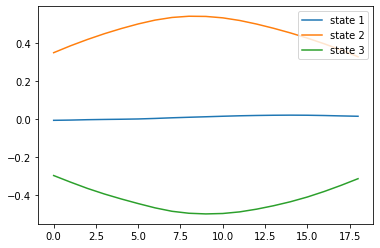




covars_:


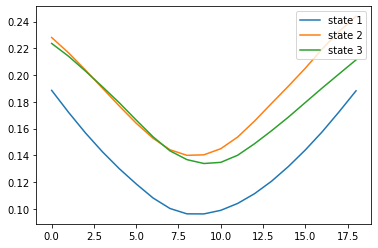

In [23]:
print("startprob_: \n", model.startprob_, "\n\n\ntransmat_: \n", model.transmat_,)

print("\n\n\nmeans_:")
plt.subplots()
for i in range(n_states):
    plt.plot(model.means_[i, 0, :])
plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
plt.show()

print("\n\n\ncovars_:")
plt.subplots()
for i in range(n_states):
    plt.plot(model.covars_[i, 0, :])
plt.legend([f'state {i+1}' for i in range(n_states)], loc='upper right')
plt.show()

In [25]:
time

array([-4.        , -3.99609375, -3.9921875 , ...,  2.9921875 ,
        2.99609375,  3.        ])